In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from functools import partial
from natsort import natsorted

import problems as pbs
import solvers as svs
from run_solvers import run
from utils import *
from dpt import DPTSolver

from torch.utils.data import DataLoader
from run_dpt import DPTSolver, custom_collate_fn, OnlineDataset, OfflineDataset
import lightning as L

Get a model from a checkpoint.

In [3]:
def get_checkpoint(run_name):
    root_dir = os.path.join("results", "training", run_name, "checkpoints")
    checkpoint = natsorted(os.listdir(root_dir))[-1]
    checkpoint_file = os.path.join(root_dir, checkpoint)
    return checkpoint_file

model = DPTSolver.load_from_checkpoint(get_checkpoint("1voui0dm")).cpu()

Get test problems.

In [4]:
problem_class = getattr(pbs, 'QUBO')
problems = pbs.deserialize_problem_set("data/QUBO_n_2_d_10/test.dill").problems

Define a budget.

In [5]:
budget = 2 * model.config["model_params"]["seq_len"]

Set a tester.

In [6]:
tester = L.Trainer(logger=False, precision=model.config["precision"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
dataset = OnlineDataset(problems)
collate_fn = partial(custom_collate_fn, problem_class=problem_class)
dataloader = DataLoader(
    dataset=dataset,
    batch_size=256,
    num_workers=24,
    pin_memory=True,
    shuffle=False,
    collate_fn=collate_fn
)

In [8]:
model.config["online_steps"] = budget
model.config["do_sample"] = False

tester.test(model=model, dataloaders=dataloader)
logs = {
    "DPT (argmax)": {
        "m_list": np.arange(budget) + 1,
        "y_list (mean)": model.trajectory.cpu().numpy()
    }
}

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [9]:
model.config["online_steps"] = budget
model.config["do_sample"] = True

tester.test(model=model, dataloaders=dataloader)
logs |= {
    "DPT (sampling)": {
        "m_list": np.arange(budget) + 1,
        "y_list (mean)": model.trajectory.cpu().numpy()
    }
}

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [12]:
dataset = OfflineDataset(problems)
dataloader = DataLoader(
    dataset=dataset,
    batch_size=256,
    num_workers=24,
    pin_memory=True,
    shuffle=False,
    collate_fn=collate_fn
)

In [13]:
model.config["online_steps"] = int(budget / 2)
model.config["do_sample"] = False

tester.test(model=model, dataloaders=dataloader)
logs |= {
    "DPT (warmup)": {
        "m_list": np.arange(budget) + 1,
        "y_list (mean)": model.trajectory.cpu().numpy()
    }
}

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

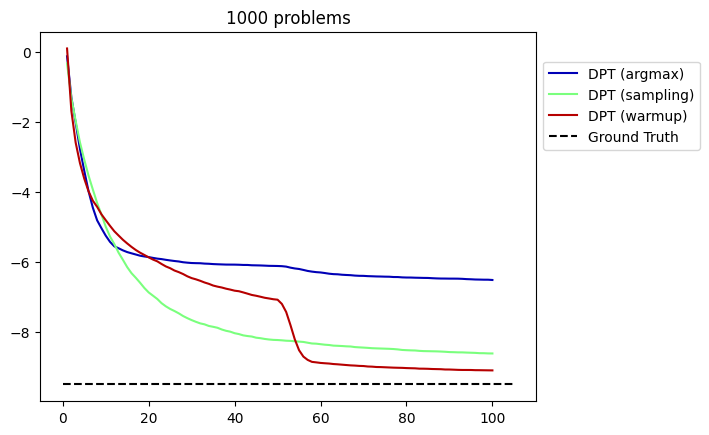

In [14]:
plot_logs(logs, problems)

Other solvers

In [15]:
solvers = [
    ("PROTES", partial(svs.PROTES, budget=budget, k_samples=20, k_top=5)),
    ("OnePlusOne", partial(svs.OnePlusOne, budget=budget)),
    ("PSO", partial(svs.PSO, budget=budget)),
    ("Portfolio", partial(svs.Portfolio, budget=budget)),
    ("RandomSearch", partial(svs.RandomSearch, budget=budget))
]

In [18]:
save_dir = "results/testing/QUBO_n_2_d_10"
# run(save_dir, problems, solvers, n_runs=10)

In [ ]:
logs |= read_problemset(save_dir, problems)

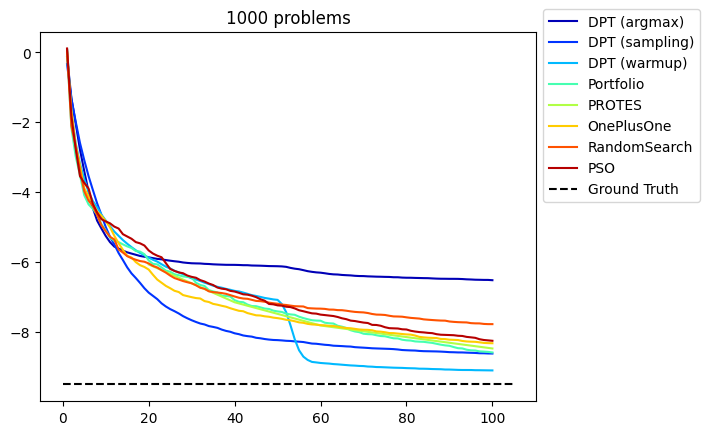

In [20]:
plot_logs(logs, problems)